<a href="https://colab.research.google.com/github/earthspecies/latent_macaque/blob/master/macaque_calls_hyperresolution_umap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install git+git://github.com/earthspecies/spectral_hyperresolution.git

  Cloning git://github.com/earthspecies/spectral_hyperresolution.git to /tmp/pip-req-build-bs0zoh4l
  Running command git clone -q git://github.com/earthspecies/spectral_hyperresolution.git /tmp/pip-req-build-bs0zoh4l
  Created wheel for spectral-hyperresolution-earthspecies: filename=spectral_hyperresolution_earthspecies-0.0.1-cp36-none-any.whl size=9510 sha256=331e4e7a42e2813071abc9665218d5ad2fb12c574f7ecc6c3e8a7df444785200
  Stored in directory: /tmp/pip-ephem-wheel-cache-gj7x1mcd/wheels/b8/1c/fc/4e5687e8f9031dddc3f18439f526a51cc669886b66da12683f
Successfully built spectral-hyperresolution-earthspecies


In [0]:
%matplotlib inline

import pathlib
import pandas as pd
import numpy as np
import librosa, librosa.display
import warnings
import matplotlib.pyplot as plt

In [3]:
!gsutil cp gs://ml-animal-sounds-datasets/Fukushima2015.pickle .

Copying gs://ml-animal-sounds-datasets/Fukushima2015.pickle...
/ [1 files][215.2 MiB/215.2 MiB]                                                
Operation completed over 1 objects/215.2 MiB.                                    


In [0]:
wav_df = pd.read_pickle('Fukushima2015.pickle')
sr = 22050

In [0]:
wav_df = wav_df[wav_df.voc_len < 0.7]

In [0]:
wav_df.vocdata = wav_df.vocdata.map(lambda x: librosa.util.pad_center(x, sr * 0.7))

In [0]:
from spectral_hyperresolution.linear_reassignment_pytorch import high_resolution_spectrogram

In [0]:
spectrogram = high_resolution_spectrogram(wav_df.iloc[0].vocdata[:, None], 1, 98, 2, 10, 50/sr, 5000/sr, 'cuda')

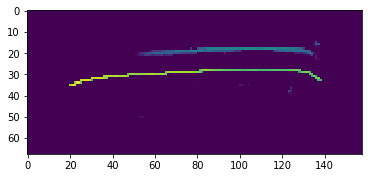

In [9]:
plt.imshow(librosa.core.amplitude_to_db(spectrogram.cpu().numpy().T));

In [0]:
def vocdata2hist(vocdata):
    spec = high_resolution_spectrogram(vocdata[:, None], 1, 98, 2, 10, 50/sr, 5000/sr, 'cuda').cpu().numpy().T
    return librosa.core.amplitude_to_db(spec)

In [11]:
%%time

wav_df['spec'] = wav_df.vocdata.map(lambda x: vocdata2hist(x))

CPU times: user 32min 15s, sys: 1min 8s, total: 33min 24s
Wall time: 33min 25s


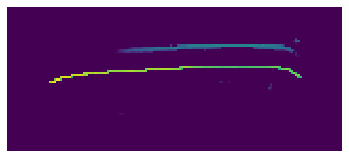

In [13]:
plt.imshow(wav_df.spec[0])
plt.axis('off');

In [0]:
import umap
import seaborn as sns

In [15]:
specs = np.stack(wav_df.spec.values)
specs_flattened = np.reshape(specs, (np.shape(specs)[0], np.prod(np.shape(specs)[1:])))
len(specs_flattened)

7008

In [16]:
fit = umap.UMAP()
%time u_all = fit.fit_transform(specs_flattened)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(parallel=True

CPU times: user 39.4 s, sys: 565 ms, total: 40 s
Wall time: 39.7 s


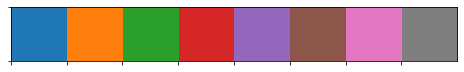

In [17]:
labs = wav_df.indv.values
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = np.array([lab_dict[i] for i in labs])

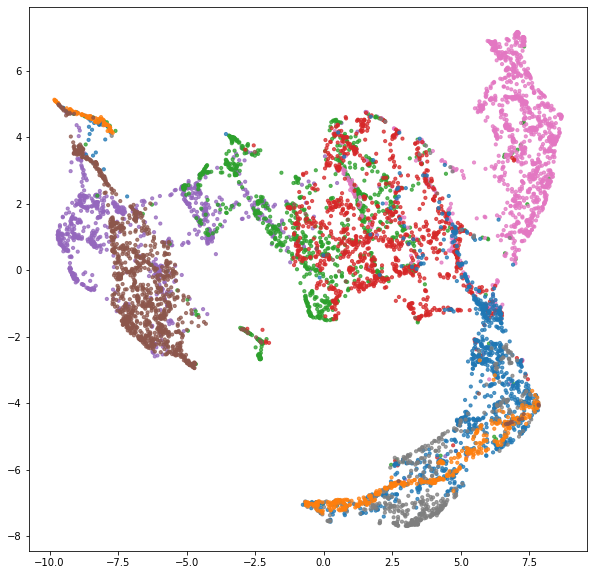

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u_all[:,0], u_all[:,1], alpha = 0.75, s=10, color=colors)